# Stable Diffusion 2.0 Inpainting Pipeline
### 1. To replace the background of original image 
### 2. Mask the intended objects in a image you want to persist
### 3. Write a simple text prompt describing how the background should look like
### 4. BAM!! Within 3 steps your new images with replaced background is ready

### Install required packages

In [1]:
# !pip install diffusers transformers accelerate

In [2]:
import torch
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

from diffusers.utils import load_image
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler, DPMSolverMultistepScheduler

### Loading the SD-2.0 Inpainting model into GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sd_pipeline = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Describe how you wish to replace the background in a simple english prompt
### If you wish to not see certain artifacts in the generated image, put them down in negative prompt

In [4]:
prompt = "Good Friday celebrations, Candles, flower decoration"
negative_prompt = "low quality, bad quality, cartoon, animation, graphics"

In [5]:
mask_blur = 18

# Load original and masked images
orig_image = load_image("167.jpg").convert("RGB").resize((512, 512))
mask_image = load_image("167_mask.jpg").convert("L").resize((512, 512))

# convert the pil images to numpy arrays for further processing
init_array = np.asarray(orig_image)
dummy_ones = np.ones((init_array.shape[0], init_array.shape[1]), dtype=np.float32)
mask = dummy_ones - np.asarray(mask_image)/255.

# blur the masked image with Gaussian blur
# blurring the objects to be persisted will prevent that object from getting deteriorted during image generation
# More you blur, more probability that it's originality will be preserved after generation of new images
mask_img = Image.fromarray(np.uint8(mask)*255).convert("L")
mask_blur_img = mask_img.filter(ImageFilter.GaussianBlur(mask_blur))

### Plotting the Original, Masked and Mask Blurred Images

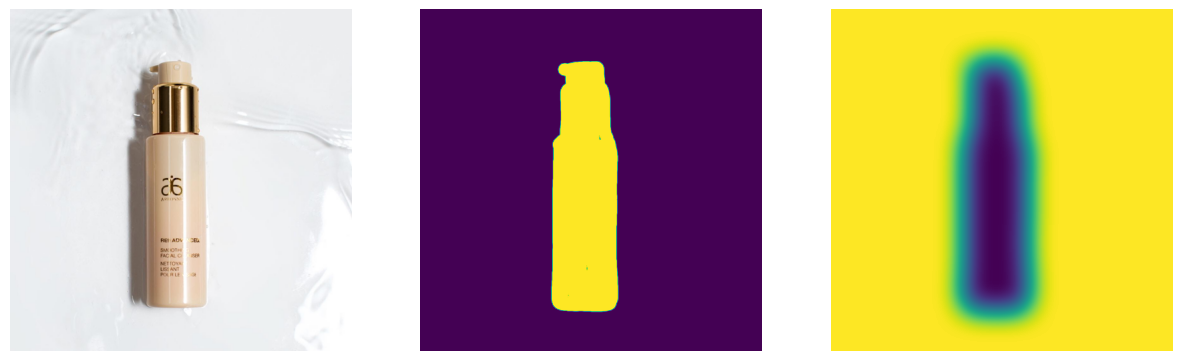

In [7]:
images = [orig_image, mask_image, mask_blur_img]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for image, ax in zip(images, axs.ravel()):
    ax.imshow(image)
    ax.axis("off")
    ax.set_xlabel("")

plt.show()

In [10]:
seed = 42

generated_images = sd_pipeline(image=orig_image,
                               mask_image=mask_blur_img,
                               prompt=prompt,
                               negative_prompt=negative_prompt,
                               height=512,
                               width=512,
                               num_inference_steps=50,
                               num_images_per_prompt=4,
                               generator = torch.Generator().manual_seed(seed)).images

  0%|          | 0/50 [00:00<?, ?it/s]

## Display Generated Images which have filled the background of original image according to the provided text prompts

In [11]:
from diffusers.utils import load_image
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

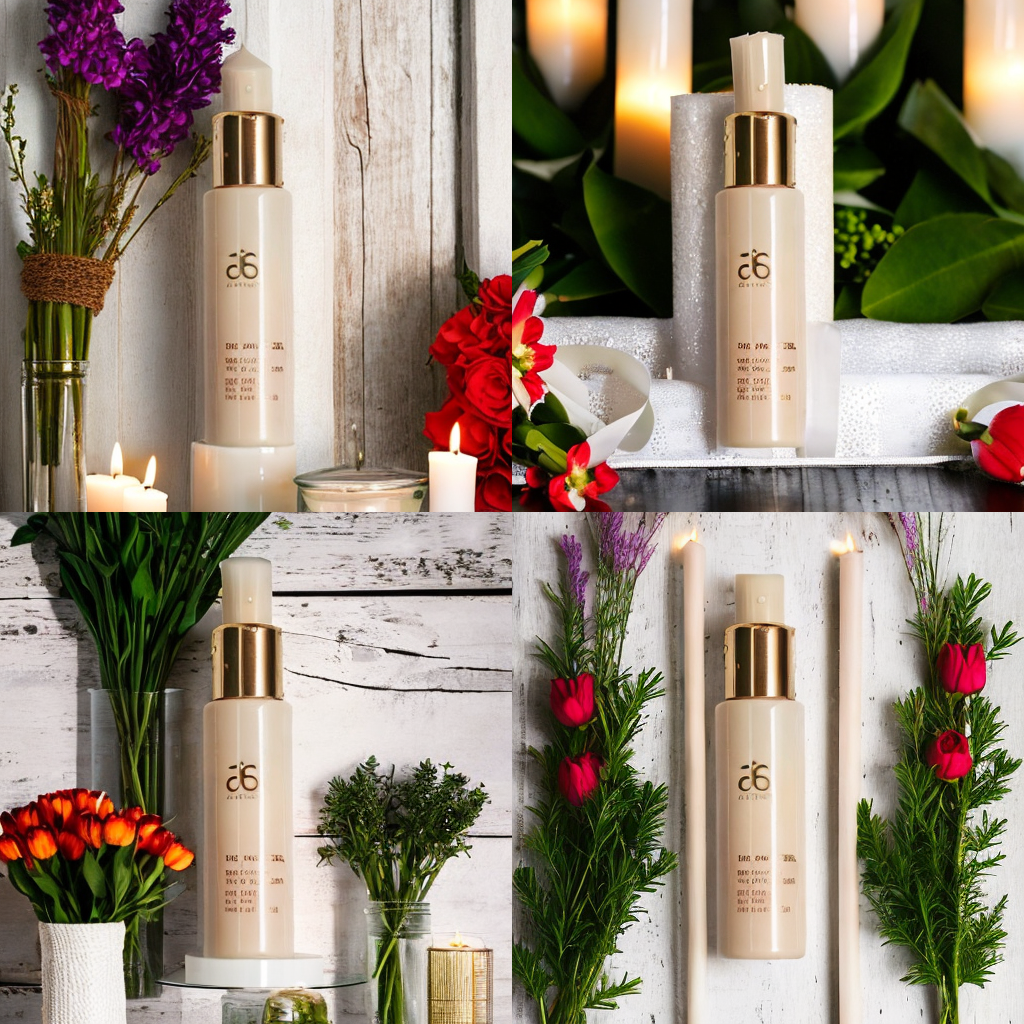

In [13]:
image_grid(generated_images, 2, 2)